In [1]:
!git clone https://github.com/XL2248/MSCTD.git

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 18.60 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read main data from drive

!unzip -q "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/train_ende.zip"
!unzip -q "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/test.zip"
!unzip -q "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/dev.zip"


In [6]:
# Import libraries

import os
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToTensor, Lambda, transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, TensorDataset, DataLoader, ConcatDataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import cv2 as cv
import numpy as np
import cv2
import dlib
import time
from __future__ import print_function, division
import copy
import pathlib

from torchsummary import summary

import random
import glob
import re


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# DataLoader

In [ ]:
# english_dev : 5063
# english_test : 5067
# english_train : 20240
# #--------------------
# german_dev : 5063
# german_test : 5067
# german_train : 20240
# #-------------------

In [27]:
y_h = lambda y : torch.zeros(3, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)
class MSCTDDataset(Dataset):
    
    def __init__(self, path_to_dataset = None, transform=None, target_transform=None):
        if path_to_dataset == 'path_to_dataset_train':
            Data = 'train'
            path_english_text = 'english_train'
            path_sentiment_text = 'sentiment_train'
            path_image = 'train_ende'
        elif path_to_dataset == 'path_to_dataset_test':
            Data = 'test'
            path_download = 'test_ende'
            path_english_text = 'english_test'
            path_sentiment_text = 'sentiment_test'
            path_image = 'test'
        elif path_to_dataset == 'path_to_dataset_dev':
            Data = 'dev'
            path_download = 'dev'
            path_english_text = 'english_dev'
            path_sentiment_text = 'sentiment_dev'
            path_image = 'dev'
        else:
            return TypeError, path_to_dataset + " is invalid"
        #!unzip "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/deepproject/train_ende.zip"
        english_text_path = f"/content/MSCTD/MSCTD_data/ende/{path_english_text}.txt"
        sentiment_path = f"/content/MSCTD/MSCTD_data/ende/{path_sentiment_text}.txt"
        self.image_path = f"/content/{path_image}/"

        with open(english_text_path) as f:
          english_text = [line.strip() for line in f.readlines()]
        print(f"{Data} english_text", len(english_text))
        self.englishtext = english_text

        with open(sentiment_path) as f:
          sentiment = [line.strip() for line in f.readlines()]
        self.sentiment = sentiment
        print(f"{Data} sentiment", len(sentiment))
        
        Images = os.listdir(self.image_path)
        Images.sort(key = lambda x:  int(x.split(".")[0]))
        self.Images = Images
        # self.target = target
        # self.features = features
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):

        # img_path = os.path.join(self.image_path, self.Images[idx])

        # img = cv.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Chnage channel due to imread function read images in BGR coding.
        sntmnt = self.sentiment[idx]
        englsh_txt = self.englishtext[idx]

        if self.target_transform:
            label = y_h(sntmnt)
        if self.transform:
            # img = cv2.resize(img,(64,64))
            # img = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])(img)
            sntmnt = int(sntmnt)
        return englsh_txt, sntmnt 

In [29]:
train = MSCTDDataset('path_to_dataset_train', target_transform = False)
test = MSCTDDataset('path_to_dataset_test', target_transform = False)
dev = MSCTDDataset('path_to_dataset_dev', target_transform = False)

train english_text 20240
train sentiment 20240
test english_text 5067
test sentiment 5067
dev english_text 5063
dev sentiment 5063


In [ ]:
image, en_text, sentiment = train[0]

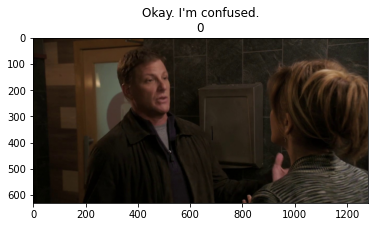

In [12]:
plt.title(en_text+"\n" + sentiment)
plt.imshow(image)

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

eng_list=[x[0] for x in train]

# tfidf = TfidfVectorizer(ngram_range=(1,5), max_features=500000)
vectorizer = TfidfVectorizer()
train_transformed = vectorizer.fit_transform(eng_list)
vectorizer.get_feature_names_out()
print("sample document:")
print(eng_list[0])
print("\nsample of tfidf vector:")
print(train_transformed[0])
print("\nsome of words that has been used as the features:")
print(vectorizer.get_feature_names_out()[1200:1220])

# train_transformed should be used to train the model.
# a good example can be found here:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

sample document:
Okay. I'm confused.

sample of tfidf vector:
  (0, 1903)	0.8884650114525932
  (0, 5859)	0.45894435765628894

some of words that has been used as the features:
['brilliant' 'brine' 'bring' 'bringing' 'brings' 'briny' 'briskly'
 'bristol' 'britain' 'british' 'bro' 'broadcast' 'broadcasters'
 'broadcasts' 'broadway' 'brochures' 'broke' 'broken' 'broker'
 'bronchitis']
